In [1]:
from lisa.utils import *
from lisa.library import *
import lisa.models
import numpy as np, pandas as pd, datetime
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

In [2]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
datastream = DataSet.objects.get(id=7)
df = datastream.dataframe
print(df.shape)
df_res = pd.DataFrame(index=df.index, columns=df.columns)
df_mean = df.mean(axis=1)
df_std = df.std(axis=1)
df_quantile_25 = df.quantile(0.25, axis=1)
df_quantile_75 = df.quantile(0.75, axis=1)

(1000, 10)


In [5]:
count=0
for index, row in df.iterrows():
    for column in df.columns:
        IQR = df_quantile_75[index] - df_quantile_25[index]
        
        if row[column] < (df_quantile_25[index] - (1.5 * IQR)) or row[column] > (df_quantile_75[index] + (1.5 * IQR)):
            df_res.loc[index, column] = 1
            count+=1
            #print(index)
            #print('Val:', np.abs(row[column]))
            #print('Mean:', df_mean[index])
            #print('2 Std:', 2*df_std[index])
print(count)
print(df_res.sum(axis=0))

10
station
39    10.0
40     NaN
41     NaN
42     NaN
43     NaN
44     NaN
45     NaN
46     NaN
47     NaN
48     NaN
dtype: float64


In [6]:
indexes = []
for index, row in df_res.iterrows():
    for column in df_res.columns:
        if row[column] == 1:
            indexes.append(index)
            break
print(len(indexes))

10


In [7]:
df_class = pd.DataFrame(index=df.index)
df_class['Class'] = 0

for index in indexes:
    df_class.loc[index,'Class'] = 1
df = df.join(df_class)

In [8]:
normal = df[df['Class'] == 0]
anomaly = df[df['Class'] == 1]

In [9]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.5, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (495, 11)
Proportion os anomaly in training set: 0.00

Valid shape:  (252, 11)
Proportion os anomaly in validation set: 0.02

Test shape:,  (253, 11)
Proportion os anomaly in test set: 0.02



In [10]:
from sklearn.ensemble import IsolationForest
np.random.seed(42)

model = IsolationForest(random_state=42, n_jobs=4, max_samples=train.shape[0], bootstrap=True, n_estimators=50)
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

-0.0660137250425
-0.101309667499


In [22]:
tresholds = np.linspace(-0.14, -0.08, 200)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.428571428571 113


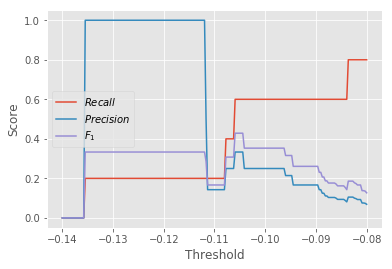

In [23]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -0.106
Test Recall Score: 0.400
Test Precision Score: 0.200
Test F1 Score: 0.267


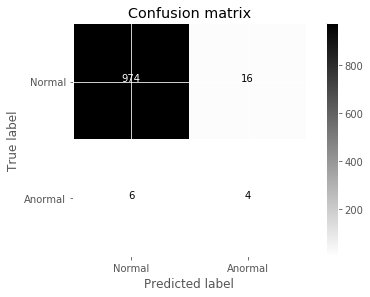

In [24]:
final_tresh = tresholds[scores[:, 2].argmax()]
df_n = df.reset_index(drop=True)
y_hat_test = (model.decision_function(df_n.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %.3f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_n['Class'].values, beta=1))

cnf_matrix = confusion_matrix(df_n['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

Final threshold: 0.010
Recall Score: 0.640
Precision Score: 0.194
F1 Score: 0.298


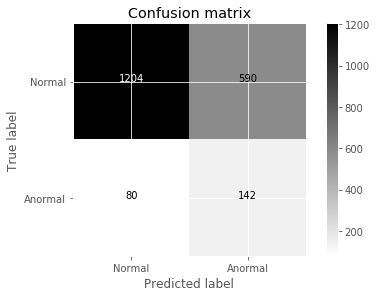

In [22]:
final_tresh = tresholds[scores[:, 2].argmax()]
df_n = df.reset_index(drop=True)
y_hat_test = (model.decision_function(df_n.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %.3f' % final_tresh)
print('Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_n['Class'].values, beta=1))

cnf_matrix = confusion_matrix(df_n['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')